In [387]:
import datetime
import matplotlib.pyplot as plt
from dateutil import tz
from astral.geocoder import database, lookup
from astral.sun import sun

Does the sunset change at irregular intervals?

At Christmas, we were discussing sunrise and sunset occuring at irregular intervals.  My speculation was that this was due to rounding errors in reporting data.  However, I'm not sure.  I expect that total day length should change on a curve, since it's due to earth's tilt and the rotation of the earth around the sun.  However, I'd like to see some more specific data.

I believe I articulated my belief that it should be a curve with an unwaranted level of confidence, so I'm quite eager to find out how it works.

We're going to be using `astral`, a Python package for calculating the times of various aspects of the sun and phases of the moon.

First we get the location information for Minneapolis:

In [388]:
city = lookup("Minneapolis", database())

city

LocationInfo(name='Minneapolis', region='USA', timezone='US/Central', latitude=44.96666666666667, longitude=-93.25)

Next lets get a single date and compare it to a known source to make sure that `astral` is working as expected.  The National Oceanic and Atmospheric Administration provides a [free resource](https://gml.noaa.gov/grad/solcalc/sunrise.html) to track the sunrise and sunset, and solar-noon with sub-second accuracy.  That should be a good point of comparison.

For December 26, 2021 the NOAA says Minneapolis should have:

```
Apparent Sunrise:  7:50    AM
Solar Noon:       12:13:33
Apparent Sunset:   4:37    PM
```

[Note that all times below are UTC, so we're going to convert them to local times.]

In [389]:
s = sun(city.observer, date=datetime.date(2021, 12, 26))
local_tz = tz.tzlocal()

print((
    f'Sunrise: {s["sunrise"].astimezone(local_tz)}\n'
    f'Noon:    {s["noon"].astimezone(local_tz)}\n'
    f'Sunset:  {s["sunset"].astimezone(local_tz)}\n'
))

Sunrise: 2021-12-26 07:50:29.424932-06:00
Noon:    2021-12-26 12:13:25-06:00
Sunset:  2021-12-26 16:37:10.489194-06:00



We're getting a difference of 7 seconds off when it comes to solar noon.  I'm going to attribute that to a mild difference in how the two systems calculate based on elevation, or a small shift in the coordinates of Minneapolis from tool to tool.

That 7 seconds is probably worth exploring, but it is outside of the scope for today.  I'm going to move on assuming that `astral` is an acceptable calculator of sunrise and sunset.

Lets now chart the next 180 days of sunsets:

Text(0, 0.5, 'Midnight to Sunset (s)')

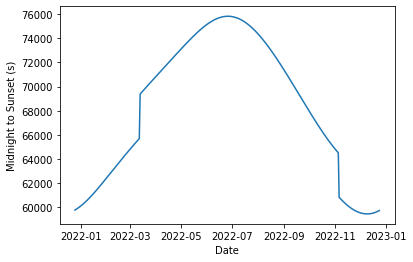

In [390]:
def get_daily_suns(city, days, start_date):
    daily_suns = []
    for delta_days in range(days):
        date = start_date + datetime.timedelta(days=delta_days)
        daily_suns.append(sun(city.observer, date=date))
    return daily_suns

def get_offset_seconds_tz(sun, event="sunset"):
    event_local = sun[event].astimezone(local_tz)
    return (event_local - event_local.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()

daily_suns = get_daily_suns(city, 365, datetime.date(2021, 12, 25))
days = [sun['sunset'].astimezone(local_tz).date() for sun in daily_suns]
sunset_offsets = [get_offset_seconds_tz(sun) for sun in daily_suns]
plt.plot(days, sunset_offsets)
plt.xlabel('Date')
plt.ylabel('Midnight to Sunset (s)')

And we see a fairly nice curve showing the number of seconds from midnight to the Sunset on the Y axis and the date on the X axis, with two huge changes.  These threw me for a minute, but they're time changes.

Rather than ensuring we keep a correct local time, going forward lets consider the sunset time in London using UTC, since that will deal with the timezones for us.

Text(0, 0.5, 'Midnight to Sunset (s)')

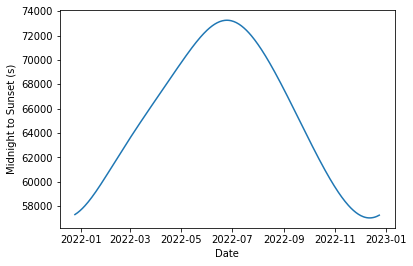

In [391]:
def get_offset_seconds(sun, event="sunset"):
    event_local = sun[event]
    return (event_local - event_local.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()

city = lookup("London", database())

daily_suns = get_daily_suns(city, 365, datetime.date(2021, 12, 25))
days = [sun['sunset'].date() for sun in daily_suns]
sunset_offsets = [get_offset_seconds(sun) for sun in daily_suns]

plt.plot(days, sunset_offsets)
plt.xlabel('Date')
plt.ylabel('Midnight to Sunset (s)')

Those are some nice curves.

The question posed wasn't whether the sunset time followed a curve, but rather whether it changed in smooth way.  Lets take a look.

Text(0, 0.5, 'Rate of Change in Midnight to Sunset (s)')

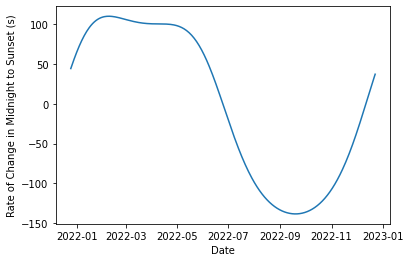

In [392]:

daily_suns = get_daily_suns(city, 365, datetime.date(2021, 12, 25))
days = [sun['sunset'].date() for sun in daily_suns]
sunset_offsets = [get_offset_seconds(sun) for sun in daily_suns]
sunset_offset_delta = []
for i in range(len(sunset_offsets) - 1):
    sunset_offset_delta.append(sunset_offsets[i+1] - sunset_offsets[i])

plt.plot(days[:-1], sunset_offset_delta)
plt.xlabel('Date')
plt.ylabel('Rate of Change in Midnight to Sunset (s)')

Interesting.  So things do seem to be pretty smooth.  Lets take a look at a small time period - just 60 days, to see if anything strange happens at a finder level of detail.

Text(0, 0.5, 'Midnight to Sunset (s)')

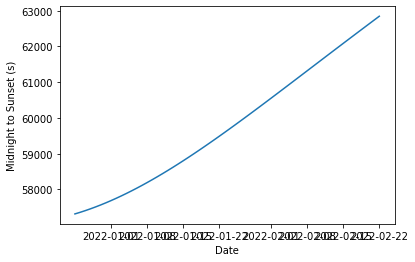

In [393]:
daily_suns = get_daily_suns(city, 60, datetime.date(2021, 12, 25))
days = [sun['sunset'].date() for sun in daily_suns]
sunset_offsets = [get_offset_seconds(sun) for sun in daily_suns]

plt.plot(days, sunset_offsets)
plt.xlabel('Date')
plt.ylabel('Midnight to Sunset (s)')

Still seems smooth to me.  However, rounding errors anywhere in here can make things get bumpy at this level of detail pretty quickly.  In fact, just testing this, I was rounding prematurely and got a bumpy result myself.  Everything was more or less correct, but at first I was convinced there was something wrong.

Just since I've got everything setup, lets do some quick calculations on total length of a day, and how that changes by lattitude.

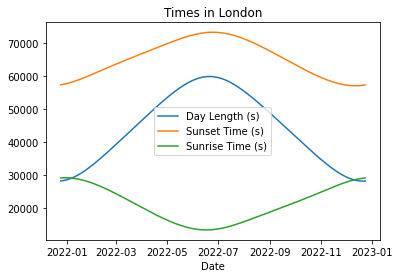

In [394]:
city = lookup("London", database())

daily_suns = get_daily_suns(city, 365, datetime.date(2021, 12, 25))
days = [sun['sunset'].date() for sun in daily_suns]
day_length = [get_offset_seconds(sun) - get_offset_seconds(sun, 'sunrise') for sun in daily_suns]
sunset_time = [get_offset_seconds(sun) for sun in daily_suns]
sunrise_time = [get_offset_seconds(sun, 'sunrise') for sun in daily_suns]

plt.plot(days, day_length, label="Day Length (s)")
plt.plot(days, sunset_time, label="Sunset Time (s)")
plt.plot(days, sunrise_time, label="Sunrise Time (s)")
plt.xlabel('Date')
plt.legend()
plt.title('Times in London')
plt.show()

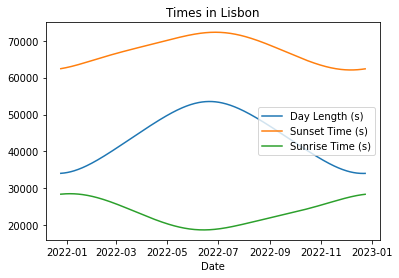

In [395]:
city = lookup("Lisbon", database())

daily_suns = get_daily_suns(city, 365, datetime.date(2021, 12, 25))
days = [sun['sunset'].date() for sun in daily_suns]
day_length = [get_offset_seconds(sun) - get_offset_seconds(sun, 'sunrise') for sun in daily_suns]
sunset_time = [get_offset_seconds(sun) for sun in daily_suns]
sunrise_time = [get_offset_seconds(sun, 'sunrise') for sun in daily_suns]

plt.plot(days, day_length, label="Day Length (s)")
plt.plot(days, sunset_time, label="Sunset Time (s)")
plt.plot(days, sunrise_time, label="Sunrise Time (s)")
plt.xlabel('Date')
plt.legend()
plt.title('Times in Lisbon')
plt.show()

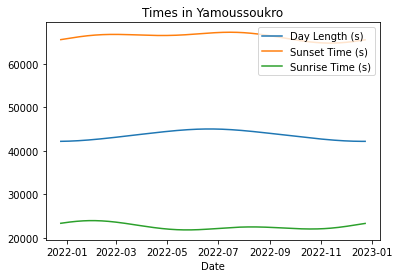

In [396]:
city = lookup("Yamoussoukro", database())

daily_suns = get_daily_suns(city, 365, datetime.date(2021, 12, 25))
days = [sun['sunset'].date() for sun in daily_suns]
day_length = [get_offset_seconds(sun) - get_offset_seconds(sun, 'sunrise') for sun in daily_suns]
sunset_time = [get_offset_seconds(sun) for sun in daily_suns]
sunrise_time = [get_offset_seconds(sun, 'sunrise') for sun in daily_suns]

plt.plot(days, day_length, label="Day Length (s)")
plt.plot(days, sunset_time, label="Sunset Time (s)")
plt.plot(days, sunrise_time, label="Sunrise Time (s)")
plt.xlabel('Date')
plt.legend()
plt.title('Times in Yamoussoukro')
plt.show()

And for good measure, lets just plot day lengths in a couple notable locations all together:

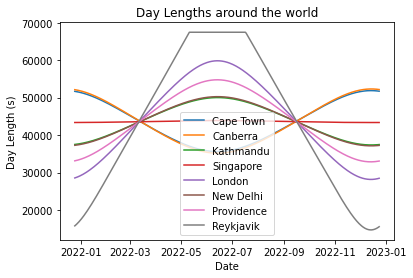

In [397]:
def safe_get_day_length(sun):
    try:
        return (get_offset_seconds(sun) - get_offset_seconds(sun, 'sunrise'))
    except: 
        return 0

def safe_get_sun(sun, city, date, tzinfo=None):
    try:
        resp = sun(city.observer, date=date, tzinfo=tzinfo)
    except:
        resp = safe_get_sun(sun, city, date - datetime.timedelta(days=1), tzinfo=tzinfo)
    return resp

def get_daily_suns(city, days, start_date, tzinfo=None):
    daily_suns = []
    for delta_days in range(days):
        date = start_date + datetime.timedelta(days=delta_days)
        daily_suns.append(safe_get_sun(sun, city, date, tzinfo=tzinfo))
    return daily_suns

def day_lengths(city_name):
    city = lookup(city_name, database())
    daily_suns = get_daily_suns(city, 365, datetime.date(2021, 1, 1), tzinfo=city.timezone)
    return [safe_get_day_length(sun) for sun in daily_suns]

cities = [
    'Cape Town',
    'Canberra',
    'Kathmandu',
    'Singapore',
    'London',
    'New Delhi',
    'Providence',
    'Reykjavik'
]

for city in cities:
    plt.plot(days, day_lengths(city), label=city)
plt.ylabel('Day Length (s)')
plt.xlabel('Date')
plt.legend()
plt.title('Day Lengths around the world')
plt.show()

And that leads me to one final question:

How many days of full sunlight does Reykjavik get per year?

In [398]:
longest_day = max(day_lengths('Reykjavik'))
len([length for length in day_lengths('Reykjavik') if (length == longest_day)])

68

68 days of full sunlight in the summers.  Wow!